## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

# Data preprocessing

## Setup code
Import some useful packages and increase the default figure size.

In [3]:
import os
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torchvision.models import densenet169
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import numpy as np
import cv2

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [4]:
if torch.cuda.is_available():
    print('Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Good to go!


# Load the dataset

Note: You need to create a dataloader to load the training and testing images.

In [5]:
class NYUDepthSubset(Dataset):
    def __init__(self, root_dir, max_samples=None):
        self.samples = []

        if any(os.path.isdir(os.path.join(root_dir, d)) for d in os.listdir(root_dir)):
            folders = sorted([os.path.join(root_dir, d) for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
            for folder in folders:
                for file in sorted(os.listdir(folder)):
                    if file.endswith('.jpg'):
                        base = file[:-4]
                        jpg_path = os.path.join(folder, f"{base}.jpg")
                        png_path = os.path.join(folder, f"{base}.png")
                        if os.path.exists(png_path):
                            self.samples.append((jpg_path, png_path))
                    if max_samples and len(self.samples) >= max_samples:
                        self.samples = self.samples[:max_samples]
                        return
        else:
            for file in sorted(os.listdir(root_dir)):
                if file.endswith('.jpg'):
                    base = file[:-4]
                    jpg_path = os.path.join(root_dir, f"{base}.jpg")
                    png_path = os.path.join(root_dir, f"{base}.png")
                    if os.path.exists(png_path):
                        self.samples.append((jpg_path, png_path))
                if max_samples and len(self.samples) >= max_samples:
                    self.samples = self.samples[:max_samples]
                    return

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, depth_path = self.samples[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)

        image = cv2.resize(image, (320, 240))
        depth = cv2.resize(depth, (320, 240))

        image = image.astype(np.float32) / 255.0
        depth = depth.astype(np.float32)
        depth = depth / (depth.max() + 1e-6)

        image = torch.from_numpy(image.transpose(2, 0, 1))
        depth = torch.from_numpy(depth).unsqueeze(0)
        return image, depth


In [6]:
data_dir = '/home/sabdulw/Desktop/unet/data2/'

image_datasets = {
    'train': NYUDepthSubset(os.path.join(data_dir, 'train'), max_samples=40687),
    'val': NYUDepthSubset(os.path.join(data_dir, 'val'), max_samples=10000)
}

print("Train size:", len(image_datasets['train']))
print("Validation size:", len(image_datasets['val']))


Train size: 40687
Validation size: 10000


## Load the data
Note:  The ImageFolder class from torchvision is used to load the images and their corresponding labels.


This section creates data loaders for training and validation sets. The batch_size parameter determines the number of samples in each batch. The shuffle=True parameter ensures that the data is shuffled during training.


In [7]:
# Create data loaders
batch_size = 32
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=8)
    for x in ['train', 'val']
}


## Visualize the loaded training and testing image pairs


Training Data:


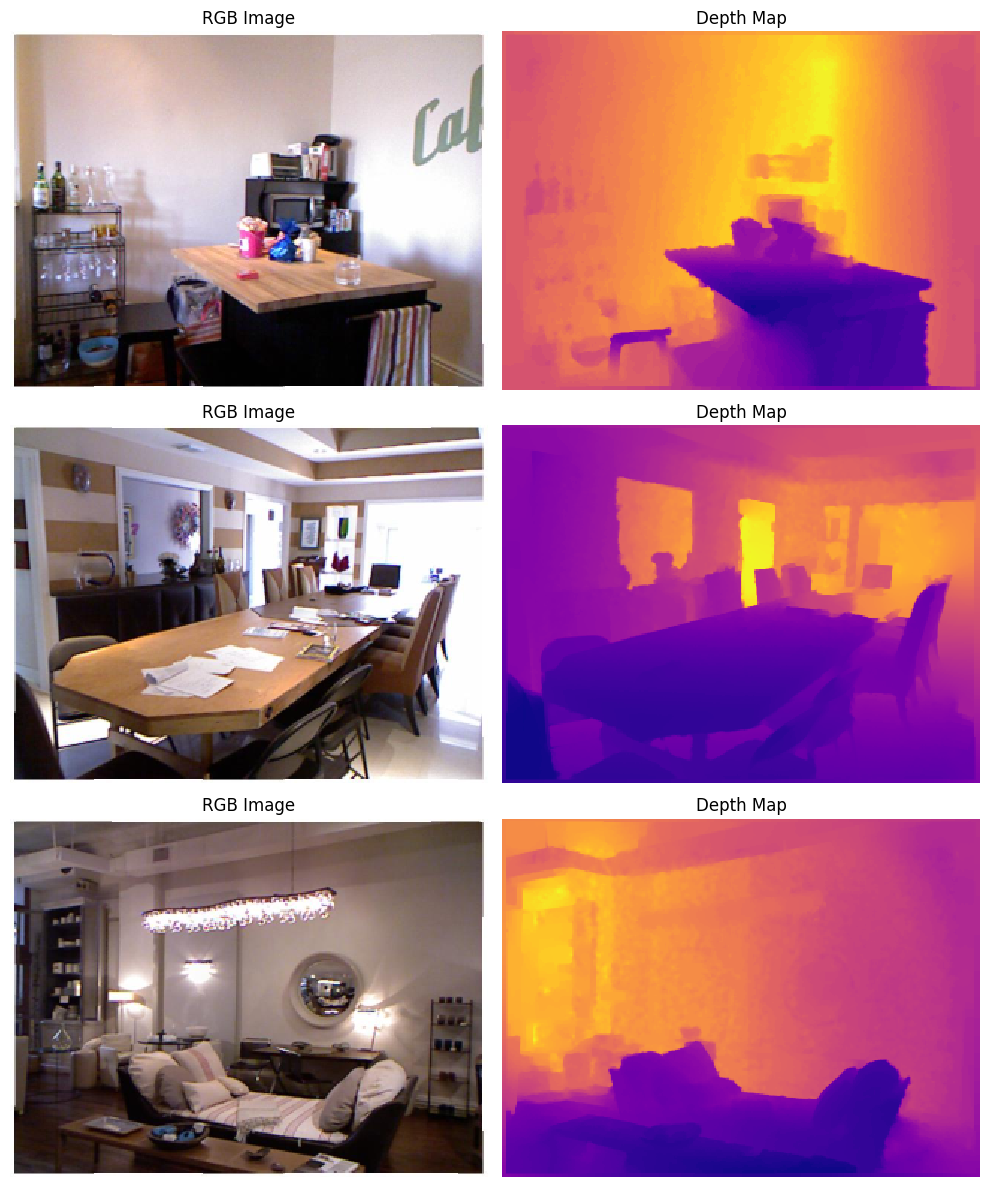


Validation Data:


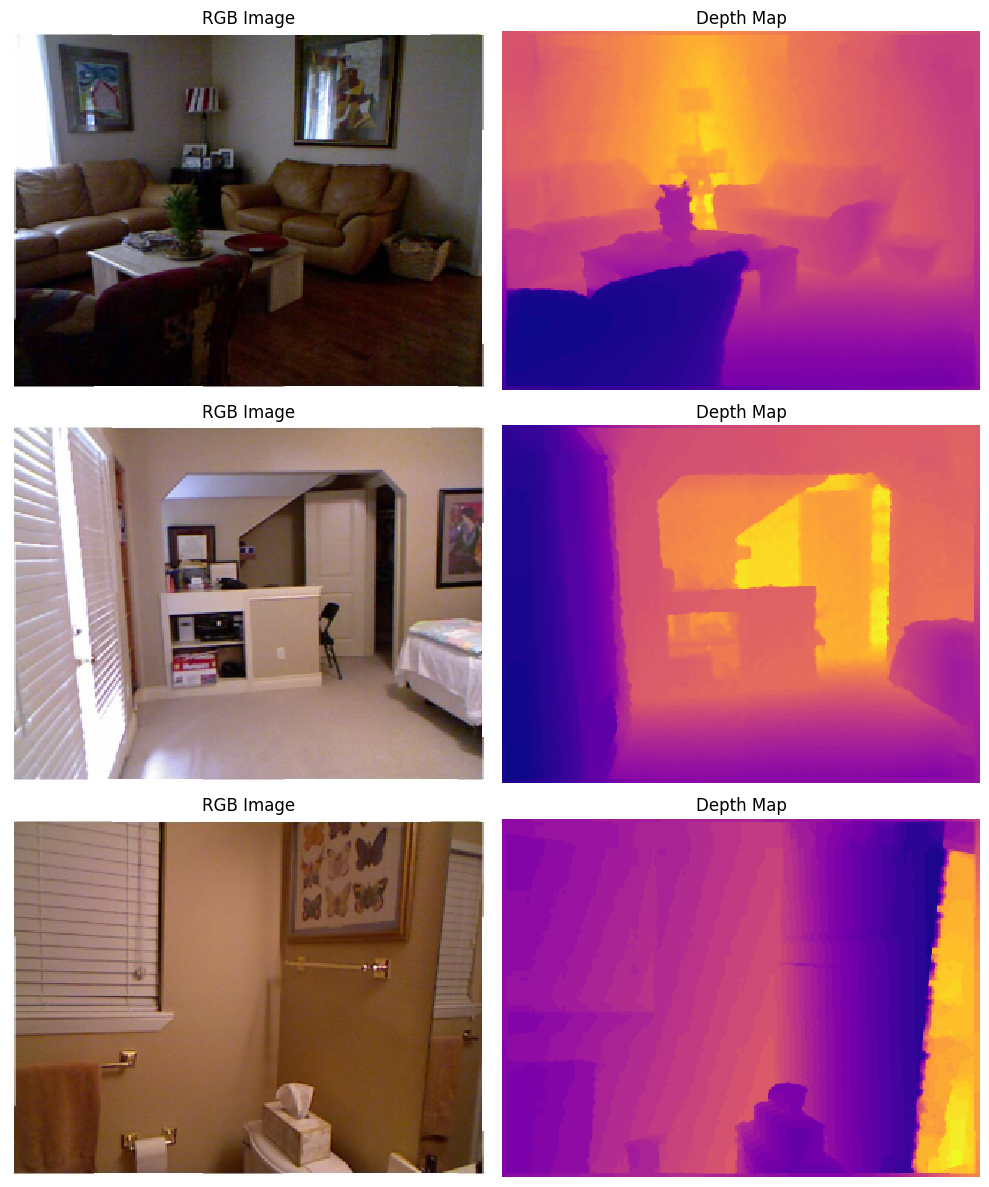

In [8]:
def visualize_data(data_loader, num_images=3):
    images, depths = next(iter(data_loader))
    plt.figure(figsize=(10, 4 * num_images))

    for i in range(num_images):
        img = images[i].permute(1, 2, 0).numpy()
        img = (img * 255).astype(np.uint8)

        depth = depths[i].squeeze().numpy()
        depth_norm = (depth - depth.min()) / (depth.max() - depth.min() + 1e-8)
        depth_uint8 = (depth_norm * 255).astype(np.uint8)
        depth_colored = cv2.applyColorMap(depth_uint8, cv2.COLORMAP_PLASMA)
        depth_colored = cv2.cvtColor(depth_colored, cv2.COLOR_BGR2RGB)

        plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(img)
        plt.title("RGB Image")
        plt.axis('off')

        plt.subplot(num_images, 2, 2*i + 2)
        plt.imshow(depth_colored)
        plt.title("Depth Map")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Print out a row of training/validation data and corresponding output images
print("Training Data:")  
visualize_data(dataloaders['train'])

print("\nValidation Data:")
visualize_data(dataloaders['val'])


# Define the Deep Learning model
Note: In this section, you define your own Deep Learning models for prediction

In [9]:
class Real3DPredictionNN(nn.Module):
    def __init__(self):
        super(Real3DPredictionNN, self).__init__()

        base = densenet169(weights=None)
        self.encoder = nn.ModuleList(list(base.features.children()))

       
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1280, 512, kernel_size=2, stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            nn.Conv2d(64, 1, kernel_size=1)
        )

    def forward(self, x):
        # Encoder forward pass
        x0 = self.encoder[0](x)   
        x1 = self.encoder[1](x0)  
        x2 = self.encoder[2](x1)  
        x3 = self.encoder[3](x2)  
        x4 = self.encoder[4](x3)  
        x5 = self.encoder[5](x4)  
        x6 = self.encoder[6](x5)  
        x7 = self.encoder[7](x6)  
        x8 = self.encoder[8](x7)  

        

        out = self.decoder(x8)
        return out

## Model Initialization
Note: This section initializes the model, loss function , and optimizer.

In [10]:
model = Real3DPredictionNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)  
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=25)



## Loss Functions


In [11]:
def Recons_loss(pred, target):  #Scale invariant loss
    pred = pred.clamp(min=1e-3)
    target = target.clamp(min=1e-3)
    diff = torch.log(pred) - torch.log(target)
    loss_val = torch.sqrt((diff ** 2).mean() - 0.5 * (diff.mean() ** 2))
    return loss_val

## Training Loop
Note: This section contains the training loop. It iterates over the specified number of epochs and trains the model on the training set. During the validation phase, it evaluates the model on the validation set without performing backpropagation and optimization. The loss for each epoch is calculated and printed.

In [12]:
# Training loop
num_epochs = 60
import matplotlib.pyplot as plt

# Training loop
train_losses = []
val_losses = []
scaler = GradScaler()

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    model.train()
    running_train_loss = 0.0
    start_time = time.time()

    train_loader = tqdm(dataloaders['train'], desc='Training', leave=False)
    for images, depths in train_loader:
        images, depths = images.to(device), depths.to(device)
        optimizer.zero_grad()

        with autocast():
            preds = model(images)
            preds = F.interpolate(preds, size=depths.shape[2:], mode='bilinear', align_corners=False)
            loss = Recons_loss(preds, depths)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_train_loss += loss.item() * images.size(0)
        train_loader.set_postfix(loss=loss.item())

    epoch_train_loss = running_train_loss / len(dataloaders['train'].dataset)
    train_losses.append(epoch_train_loss)

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    val_loader = tqdm(dataloaders['val'], desc='Validation', leave=False)
    with torch.no_grad():
        for images, depths in val_loader:
            images, depths = images.to(device), depths.to(device)
            with autocast():
                preds = model(images)
                preds = F.interpolate(preds, size=depths.shape[2:], mode='bilinear', align_corners=False)
                loss = Recons_loss(preds, depths)
            running_val_loss += loss.item() * images.size(0)
            val_loader.set_postfix(loss=loss.item())

    epoch_val_loss = running_val_loss / len(dataloaders['val'].dataset)
    val_losses.append(epoch_val_loss)

    # Epoch time and speed
    end_time = time.time()
    epoch_duration = end_time - start_time
    steps = len(dataloaders['train'])
    speed = steps / epoch_duration

    print(f"Epoch {epoch+1} Completed in {epoch_duration:.2f}s "
          f"({speed:.2f} it/s) | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

        
# Save the trained model
torch.save(model.state_dict(), 'depth_model_cc.pth')

/local_scratch/slurm.2782711/ipykernel_4069816/127108016.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Epoch 1/60


Training:   0%|                                        | 0/1272 [00:00<?, ?it/s]/local_scratch/slurm.2782711/ipykernel_4069816/127108016.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation:   0%|                                       | 0/313 [00:00<?, ?it/s]/local_scratch/slurm.2782711/ipykernel_4069816/127108016.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
                                                                                

Epoch 1 Completed in 115.82s (10.98 it/s) | Train Loss: 0.4323 | Val Loss: 0.3510

Epoch 2/60


Epoch 2 Completed in 102.31s (12.43 it/s) | Train Loss: 0.2998 | Val Loss: 0.2704

Epoch 3/60


Epoch 3 Completed in 101.03s (12.59 it/s) | Train Loss: 0.2376 | Val Loss: 0.2304

Epoch 4/60


Epoch 4 Completed in 102.84s (12.37 it/s) | Train Loss: 0.2066 | Val Loss: 0.2037

Epoch 5/60


Epoch 5 Completed in 101.90s (12.48 it/s) | Train Loss: 0.1881 | Val Loss: 0.1757

Epoch 6/60


Epoch 6 Completed in 101.79s (12.50 it/s) | Train Loss: 0.1756 | Val Loss: 0.1636

Epoch 7/60


Epoch 7 Completed in 102.75s (12.38 it/s) | Train Loss: 0.1654 | Val Loss: 0.1548

Epoch 8/60


Epoch 8 Completed in 103.01s (12.35 it/s) | Train Loss: 0.1617 | Val Loss: 0.1573

Epoch 9/60


Epoch 9 Completed in 103.25s (12.32 it/s) | Train Loss: 0.1529 | Val Loss: 0.1450

Epoch 10/60


Epoch 10 Completed in 102.15s (12.45 it/s) | Train Loss: 0.1487 | Val Loss: 0.1370

Epoch 11/60


Epoch 11 Completed in 103.46s (12.29 it/s) | Train Loss: 0.1436 | Val Loss: 0.1359

Epoch 12/60


Epoch 12 Completed in 105.90s (12.01 it/s) | Train Loss: 0.1412 | Val Loss: 0.1421

Epoch 13/60


Epoch 13 Completed in 104.78s (12.14 it/s) | Train Loss: 0.1449 | Val Loss: 0.1352

Epoch 14/60


Epoch 14 Completed in 103.90s (12.24 it/s) | Train Loss: 0.1362 | Val Loss: 0.1304

Epoch 15/60


Epoch 15 Completed in 105.44s (12.06 it/s) | Train Loss: 0.1314 | Val Loss: 0.1431

Epoch 16/60


Epoch 16 Completed in 106.05s (11.99 it/s) | Train Loss: 0.1366 | Val Loss: 0.1319

Epoch 17/60


Epoch 17 Completed in 103.77s (12.26 it/s) | Train Loss: 0.1306 | Val Loss: 0.1263

Epoch 18/60


Epoch 18 Completed in 103.34s (12.31 it/s) | Train Loss: 0.1276 | Val Loss: 0.1248

Epoch 19/60


Epoch 19 Completed in 103.04s (12.35 it/s) | Train Loss: 0.1269 | Val Loss: 0.1305

Epoch 20/60


Epoch 20 Completed in 103.21s (12.32 it/s) | Train Loss: 0.1317 | Val Loss: 0.1255

Epoch 21/60


Epoch 21 Completed in 103.04s (12.34 it/s) | Train Loss: 0.1238 | Val Loss: 0.1190

Epoch 22/60


Epoch 22 Completed in 104.87s (12.13 it/s) | Train Loss: 0.1241 | Val Loss: 0.1179

Epoch 23/60


Epoch 23 Completed in 104.61s (12.16 it/s) | Train Loss: 0.1216 | Val Loss: 0.1190

Epoch 24/60


Epoch 24 Completed in 102.73s (12.38 it/s) | Train Loss: 0.1217 | Val Loss: 0.1176

Epoch 25/60


Epoch 25 Completed in 104.35s (12.19 it/s) | Train Loss: 0.1204 | Val Loss: 0.1162

Epoch 26/60


Epoch 26 Completed in 102.67s (12.39 it/s) | Train Loss: 0.1202 | Val Loss: 0.1147

Epoch 27/60


Epoch 27 Completed in 102.57s (12.40 it/s) | Train Loss: 0.1230 | Val Loss: 0.1330

Epoch 28/60


Epoch 28 Completed in 105.11s (12.10 it/s) | Train Loss: 0.1269 | Val Loss: 0.1153

Epoch 29/60


Epoch 29 Completed in 102.72s (12.38 it/s) | Train Loss: 0.1140 | Val Loss: 0.1114

Epoch 30/60


Epoch 30 Completed in 101.36s (12.55 it/s) | Train Loss: 0.1197 | Val Loss: 0.1173

Epoch 31/60


Epoch 31 Completed in 105.01s (12.11 it/s) | Train Loss: 0.1167 | Val Loss: 0.1229

Epoch 32/60


Epoch 32 Completed in 102.43s (12.42 it/s) | Train Loss: 0.1156 | Val Loss: 0.1343

Epoch 33/60


Epoch 33 Completed in 102.78s (12.38 it/s) | Train Loss: 0.1194 | Val Loss: 0.1120

Epoch 34/60


Epoch 34 Completed in 104.15s (12.21 it/s) | Train Loss: 0.1175 | Val Loss: 0.1266

Epoch 35/60


Epoch 35 Completed in 102.72s (12.38 it/s) | Train Loss: 0.1133 | Val Loss: 0.1165

Epoch 36/60


Epoch 36 Completed in 102.59s (12.40 it/s) | Train Loss: 0.1150 | Val Loss: 0.1171

Epoch 37/60


Epoch 37 Completed in 102.25s (12.44 it/s) | Train Loss: 0.1154 | Val Loss: 0.1547

Epoch 38/60


Epoch 38 Completed in 105.74s (12.03 it/s) | Train Loss: 0.1169 | Val Loss: 0.1108

Epoch 39/60


Epoch 39 Completed in 105.32s (12.08 it/s) | Train Loss: 0.1129 | Val Loss: 0.1126

Epoch 40/60


Epoch 40 Completed in 104.85s (12.13 it/s) | Train Loss: 0.1205 | Val Loss: 0.1123

Epoch 41/60


Epoch 41 Completed in 104.31s (12.19 it/s) | Train Loss: 0.1112 | Val Loss: 0.1088

Epoch 42/60


Epoch 42 Completed in 102.98s (12.35 it/s) | Train Loss: 0.1092 | Val Loss: 0.1078

Epoch 43/60


Epoch 43 Completed in 103.63s (12.27 it/s) | Train Loss: 0.1134 | Val Loss: 0.1187

Epoch 44/60


Epoch 44 Completed in 102.82s (12.37 it/s) | Train Loss: 0.1216 | Val Loss: 0.1150

Epoch 45/60


Epoch 45 Completed in 102.30s (12.43 it/s) | Train Loss: 0.1147 | Val Loss: 0.1100

Epoch 46/60


Epoch 46 Completed in 102.91s (12.36 it/s) | Train Loss: 0.1078 | Val Loss: 0.1083

Epoch 47/60


Epoch 47 Completed in 104.08s (12.22 it/s) | Train Loss: 0.1212 | Val Loss: 0.1201

Epoch 48/60


Epoch 48 Completed in 103.45s (12.30 it/s) | Train Loss: 0.1109 | Val Loss: 0.1216

Epoch 49/60


Epoch 49 Completed in 104.78s (12.14 it/s) | Train Loss: 0.1084 | Val Loss: 0.1066

Epoch 50/60


Epoch 50 Completed in 103.02s (12.35 it/s) | Train Loss: 0.1126 | Val Loss: 0.1377

Epoch 51/60


Epoch 51 Completed in 104.29s (12.20 it/s) | Train Loss: 0.1112 | Val Loss: 0.1086

Epoch 52/60


Epoch 52 Completed in 102.64s (12.39 it/s) | Train Loss: 0.1085 | Val Loss: 0.1053

Epoch 53/60


Epoch 53 Completed in 103.55s (12.28 it/s) | Train Loss: 0.1084 | Val Loss: 0.1185

Epoch 54/60


Epoch 54 Completed in 101.97s (12.47 it/s) | Train Loss: 0.1106 | Val Loss: 0.1148

Epoch 55/60


Epoch 55 Completed in 102.61s (12.40 it/s) | Train Loss: 0.1116 | Val Loss: 0.1209

Epoch 56/60


Epoch 56 Completed in 104.05s (12.23 it/s) | Train Loss: 0.1118 | Val Loss: 0.1081

Epoch 57/60


Epoch 57 Completed in 102.27s (12.44 it/s) | Train Loss: 0.1069 | Val Loss: 0.1066

Epoch 58/60


Epoch 58 Completed in 102.67s (12.39 it/s) | Train Loss: 0.1127 | Val Loss: 0.1079

Epoch 59/60


Epoch 59 Completed in 103.05s (12.34 it/s) | Train Loss: 0.1129 | Val Loss: 0.1071

Epoch 60/60


Epoch 60 Completed in 103.36s (12.31 it/s) | Train Loss: 0.1060 | Val Loss: 0.1102


## Visualize the Training Curve and Validation Results
Note: In this section, you visualize the Training curve in the training loop and print out the first 10 validation data in the order of: input image- prediction - groundtruth 

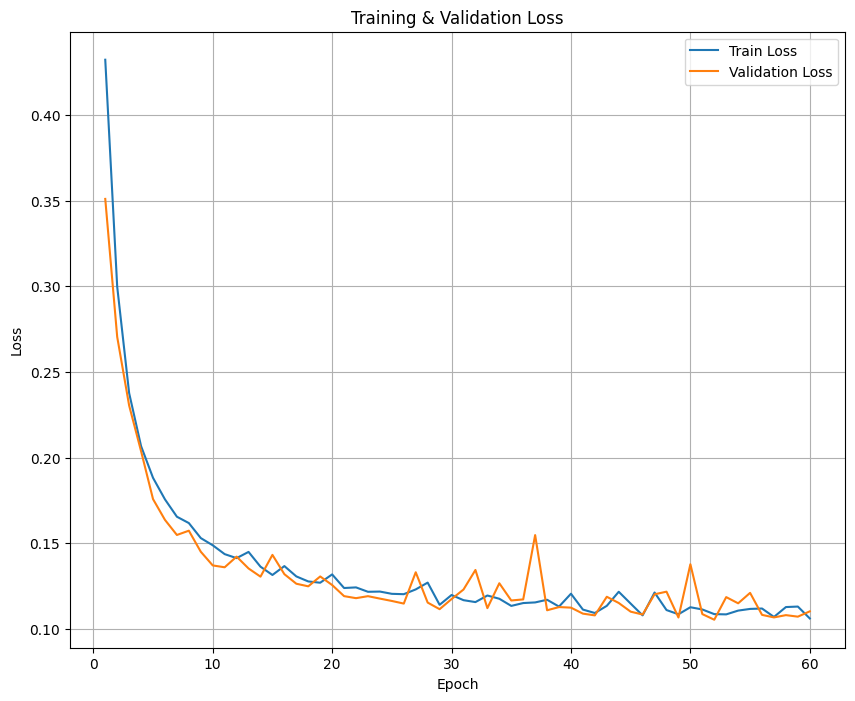

In [13]:
# Plot the validation results: input image-ouput depthmap - groundtruth depthmap
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

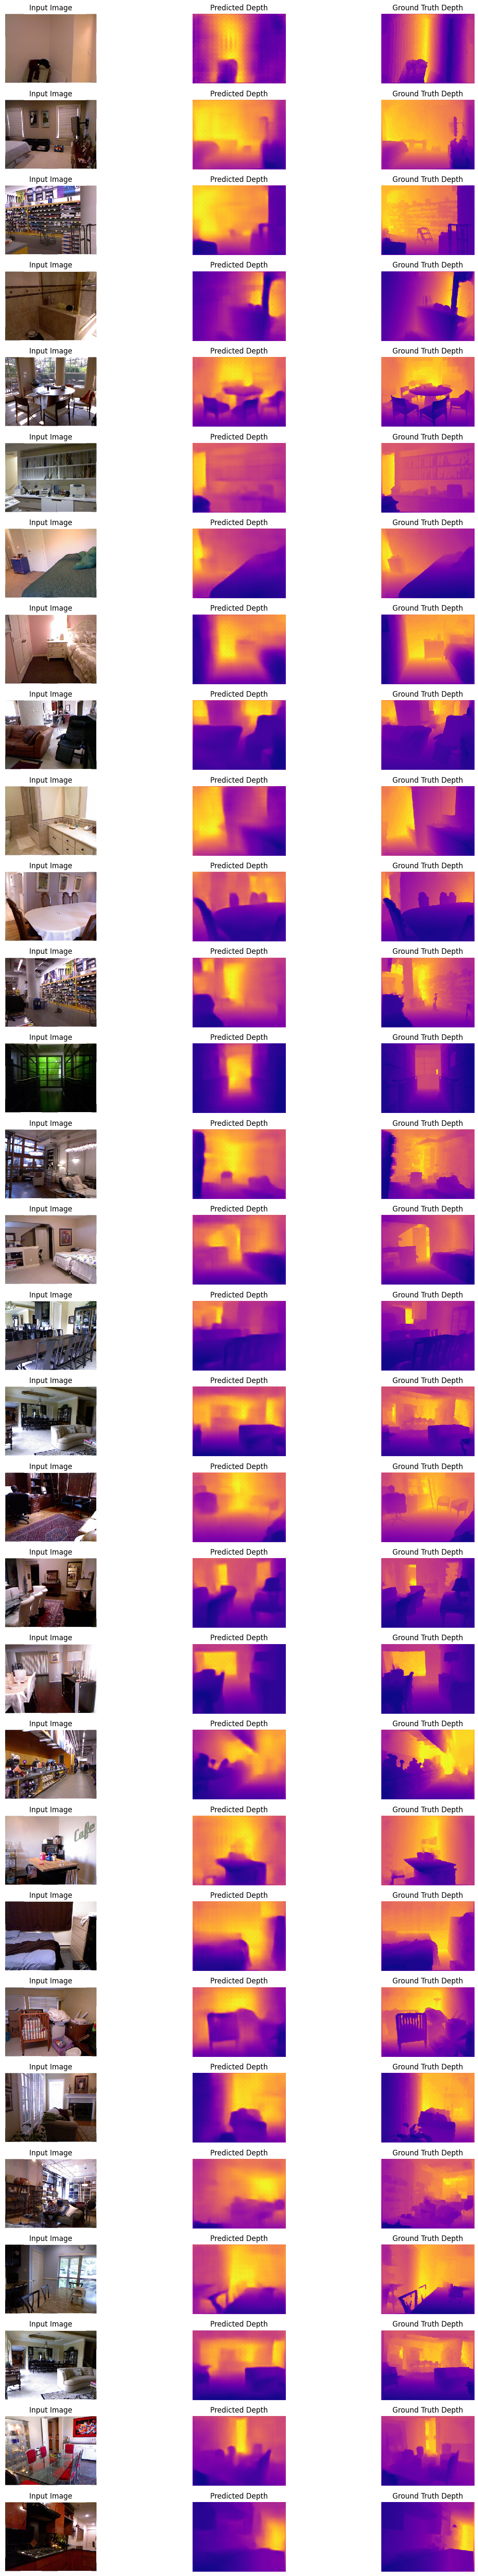

In [14]:
model.eval()
num_display = 30
collected_images = []
collected_depths = []
collected_preds = []

with torch.no_grad():
    for images, depths in dataloaders['val']:
        images = images.to(device)
        preds = model(images)
        preds = F.interpolate(preds, size=depths.shape[2:], mode='bilinear', align_corners=False)
        preds = preds.cpu()

        for i in range(images.size(0)):
            collected_images.append(images[i].cpu())
            collected_depths.append(depths[i])
            collected_preds.append(preds[i])
            if len(collected_images) == num_display:
                break
        if len(collected_images) == num_display:
            break

plt.figure(figsize=(15, num_display * 2))
for i in range(num_display):
    rgb = collected_images[i].permute(1, 2, 0).numpy()
    rgb = (rgb * 255).astype(np.uint8)

    # Normalize and colorize predicted depth
    pred = collected_preds[i].squeeze().numpy()
    pred_norm = (pred - pred.min()) / (pred.max() - pred.min() + 1e-8)
    pred_colored = cv2.applyColorMap((pred_norm * 255).astype(np.uint8), cv2.COLORMAP_PLASMA)
    pred_colored = cv2.cvtColor(pred_colored, cv2.COLOR_BGR2RGB)

    # Normalize and colorize ground truth depth
    gt = collected_depths[i].squeeze().numpy()
    gt_norm = (gt - gt.min()) / (gt.max() - gt.min() + 1e-8)
    gt_colored = cv2.applyColorMap((gt_norm * 255).astype(np.uint8), cv2.COLORMAP_PLASMA)
    gt_colored = cv2.cvtColor(gt_colored, cv2.COLOR_BGR2RGB)

    plt.subplot(num_display, 3, 3*i + 1)
    plt.imshow(rgb)
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(num_display, 3, 3*i + 2)
    plt.imshow(pred_colored)
    plt.title("Predicted Depth")
    plt.axis('off')

    plt.subplot(num_display, 3, 3*i + 3)
    plt.imshow(gt_colored)
    plt.title("Ground Truth Depth")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [15]:
def compute_errors(gt, pred):
    """Compute various depth estimation errors"""
    thresh = torch.max((gt / pred), (pred / gt))
    a1 = (thresh < 1.25).float().mean().item()
    a2 = (thresh < 1.25 ** 2).float().mean().item()
    a3 = (thresh < 1.25 ** 3).float().mean().item()

    abs_rel = torch.mean(torch.abs(gt - pred) / gt).item()
    sq_rel = torch.mean(((gt - pred) ** 2) / gt).item()

    rmse = torch.sqrt(torch.mean((gt - pred) ** 2)).item()
    rmse_log = torch.sqrt(torch.mean((torch.log(gt) - torch.log(pred)) ** 2)).item()

    # Scale-invariant loss
    diff = torch.log(pred) - torch.log(gt)
    sc_inv = torch.mean(diff ** 2) - (torch.mean(diff) ** 2) / 2
    sc_inv = sc_inv.sqrt().item()

    return a1, a2, a3, abs_rel, sq_rel, rmse, rmse_log, sc_inv

# Compute on full validation set
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, depths in dataloaders['val']:
        images = images.to(device)
        depths = depths.to(device)

        preds = model(images)
        preds = F.interpolate(preds, size=depths.shape[2:], mode='bilinear', align_corners=False)
        preds = preds.clamp(min=1e-3)
        depths = depths.clamp(min=1e-3)

        all_preds.append(preds.cpu())
        all_targets.append(depths.cpu())

# Concatenate all batches
all_preds = torch.cat(all_preds, dim=0).squeeze(1)
all_targets = torch.cat(all_targets, dim=0).squeeze(1)

# Compute all metrics
a1, a2, a3, abs_rel, sq_rel, rmse, rmse_log, sc_inv = compute_errors(all_targets, all_preds)

print(f"delta < 1.25     : {a1:.4f}")
print(f"delta < 1.25²    : {a2:.4f}")
print(f"delta < 1.25³    : {a3:.4f}")
print(f"Abs Rel      : {abs_rel:.4f}")
print(f"Sq Rel       : {sq_rel:.4f}")
print(f"RMSE         : {rmse:.4f}")
print(f"RMSE (log)   : {rmse_log:.4f}")
print(f"Sc-Inv Error : {sc_inv:.4f}")


delta < 1.25     : 0.9544
delta < 1.25²    : 0.9914
delta < 1.25³    : 0.9970
Abs Rel      : 0.0746
Sq Rel       : 0.0063
RMSE         : 0.0562
RMSE (log)   : 0.1131
Sc-Inv Error : 0.1131
